In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
mask = cv2.imread('segmask-fullres.png')

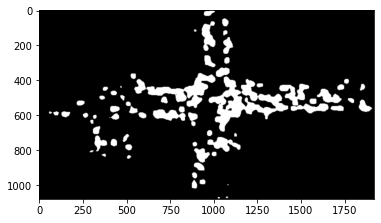

In [3]:
plt.imshow(mask)

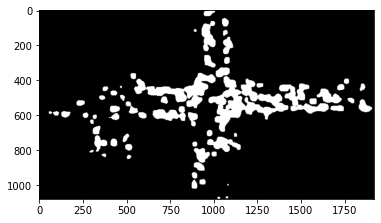

In [4]:
mask[mask>0]=255
plt.imshow(mask)

In [5]:
np.unique(mask)

array([  0, 255], dtype=uint8)

In [30]:
win_size = (512, 512)

def findBboxes(label, original_shape, current_shape, padding=0):
    H,W = original_shape
    _H,_W = current_shape
    # label[label>0] = 255
    contours = cv2.findContours(label, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    if len(contours) == 0:
        return np.empty((0,4))
    
    bboxes = []
    for i, cntr in enumerate(contours):
        x,y,w,h = cv2.boundingRect(cntr)
        xmin, ymin = (x/_W)*W, (y/_H)*H
        xmax, ymax = ((x+w)/_W)*W, ((y+h)/_H)*H

        xmin, ymin = max(0, xmin-padding), max(0, ymin-padding) # experimental - add padding
        xmax, ymax = min(W, xmax+padding), min(H, ymax+padding)
        
        bbox = [int(x) for x in [xmin,ymin,xmax,ymax]]
        bboxes.append(bbox)
    return np.array(bboxes), contours


def plot_one_box(bbox, img, color, label=None, lw=4, draw_label=True):
    
    xmin,ymin,xmax,ymax = list(map(int, bbox))
    img = cv2.rectangle(img, (xmin,ymin), (xmax,ymax), color, lw)

    if draw_label:
        ((text_width, text_height), _) = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.45, 1)
        img = cv2.rectangle(img, (xmin, ymin - int(1.3 * text_height)), (xmin + text_width, ymin), color, -1)
        
        img = cv2.putText(
            img,
            text=label,
            org=(xmin, ymin - int(0.3 * text_height)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.45,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
    )
    return img

In [31]:
H,W,C = mask.shape
H,W,C

(1080, 1920, 3)

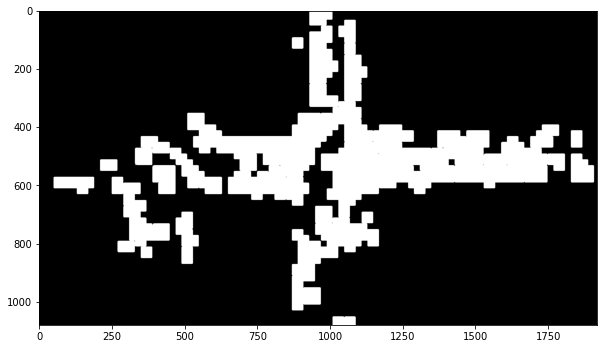

In [32]:
mask_ud = cv2.resize(cv2.resize(mask, (W//20, H//20)), (W,H))
mask_ud[mask_ud>0]=255
plt.figure(figsize=(10,10))
plt.imshow(mask_ud)

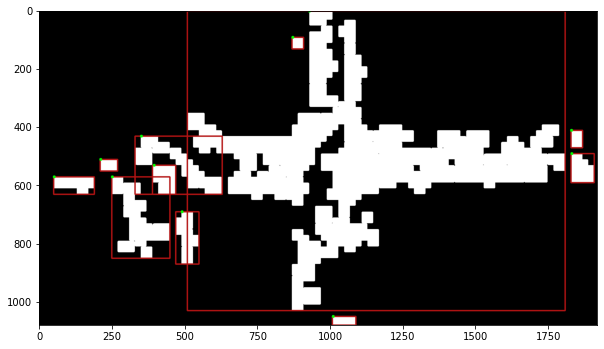

In [41]:
# bboxes = findBboxes(mask[:,:,0], mask.shape[:2], mask.shape[:2])
bboxes, contours = findBboxes(mask_ud[:,:,0], mask_ud.shape[:2], mask_ud.shape[:2])


mask_countours = mask_ud.copy()
for bbox in bboxes:
    xmin,ymin,xmax,ymax = bbox
    # print(ymax-ymin, xmax-xmin)
    mask_countours = plot_one_box(bbox, mask_countours, (180,20,20), draw_label=False)
    
for contour in contours:
    mask_countours = cv2.drawContours(mask_countours, contour, 0, (0, 255, 0), 10)
    
plt.figure(figsize=(10,10))
plt.imshow(mask_countours)

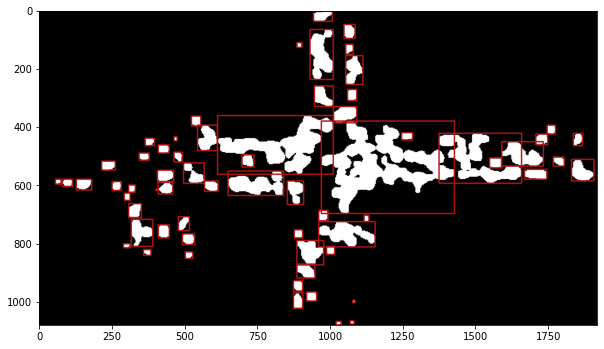

In [8]:
# bboxes = findBboxes(mask[:,:,0], mask.shape[:2], mask.shape[:2])
bboxes = findBboxes(mask_ud[:,:,0], mask_ud.shape[:2], mask_ud.shape[:2])


mask_countours = mask_ud.copy()
for bbox in bboxes:
    xmin,ymin,xmax,ymax = bbox
    # print(ymax-ymin, xmax-xmin)
    mask_countours = plot_one_box(bbox, mask_countours, (180,20,20), draw_label=False)
    
plt.figure(figsize=(10,10))
plt.imshow(mask_countours)

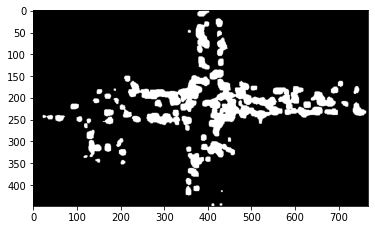

In [36]:
mask_small = cv2.resize(mask, (768, 448))
mask_small[mask_small>0]=255

plt.imshow(mask_small)

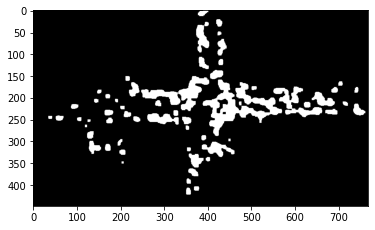

In [56]:
seg_mask = cv2.erode(mask_small.copy(), np.ones((7,7), np.uint8), iterations = 1)
seg_mask = cv2.dilate(seg_mask, np.ones((5,5), np.uint8), iterations = 1)
seg_mask[seg_mask>0]=255

plt.imshow(seg_mask)

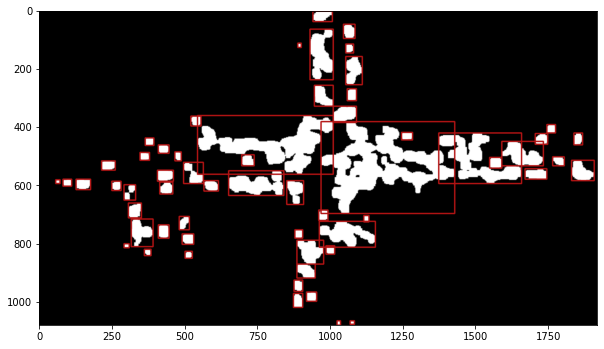

In [55]:
bboxes = findBboxes(seg_mask[:,:,0], mask.shape[:2], seg_mask.shape[:2])
h,w = mask.shape[:2]
mask_countours = cv2.resize(seg_mask, (w,h)).copy()
for bbox in bboxes:
    xmin,ymin,xmax,ymax = bbox
    # print(ymax-ymin, xmax-xmin)
    mask_countours = plot_one_box(bbox, mask_countours, (180,20,20), draw_label=False)
    
plt.figure(figsize=(10,10))
plt.imshow(mask_countours)

In [57]:
df = pd.read_csv('/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/debug-errors/after-ZF-changes/roi-track-p10-d7-letterbox-bintrk-metrics-SDS-Zebra.csv')
df

,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,APl,AR1,AR10,AR100,ARu,ARvt,ARt,ARs,ARm,ARl
0,roi-p10-d7-letterbox,Zebra,75.988558,94.522719,85.227010,-100.0,0.000000,38.743867,71.360758,82.564220,-100.000000,30.391577,80.307844,80.308460,-100.0,0.000000,53.392405,76.981132,86.135498,-100.000000
1,roi-p10-d7-letterbox,SDS,48.552445,81.087061,50.283044,-100.0,28.554778,46.334300,57.363699,33.588121,69.242939,25.057712,58.044441,58.063227,-100.0,35.063974,59.075447,67.192661,39.123911,75.234176
2,roi-p10-d7-letterbox,SDS-crops,46.609705,82.705995,45.865037,-100.0,30.034673,43.294740,54.585127,33.195957,66.641826,24.179847,56.729774,56.744079,-100.0,35.281411,56.026487,64.988313,40.239003,72.147742
3,roi-track-p10-d7-letterbox-bintrk,Zebra,81.808269,97.430950,91.038278,-100.0,0.000000,44.435019,77.928490,87.701972,-100.000000,31.190124,85.084349,85.086812,-100.0,0.000000,52.632911,82.407090,90.446013,-100.000000
4,roi-track-p10-d7-letterbox-bintrk,SDS,48.747660,81.545048,50.435044,-100.0,28.315135,46.983011,57.403385,32.628042,62.818070,25.319970,58.295980,58.311801,-100.0,34.816170,60.189601,67.129683,37.557616,70.997535
5,roi-track-p10-d7-letterbox-bintrk,SDS-crops,46.794956,83.239202,45.894395,-100.0,30.316387,43.951971,54.430579,32.534959,63.078985,24.461542,57.046541,57.065724,-100.0,35.513111,56.953444,64.943200,39.471989,70.201177


In [58]:
df = df[df.dataset.isin(['SDS', 'SDS-crops'])]
df

,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,APl,AR1,AR10,AR100,ARu,ARvt,ARt,ARs,ARm,ARl
1,roi-p10-d7-letterbox,SDS,48.552445,81.087061,50.283044,-100.0,28.554778,46.334300,57.363699,33.588121,69.242939,25.057712,58.044441,58.063227,-100.0,35.063974,59.075447,67.192661,39.123911,75.234176
2,roi-p10-d7-letterbox,SDS-crops,46.609705,82.705995,45.865037,-100.0,30.034673,43.294740,54.585127,33.195957,66.641826,24.179847,56.729774,56.744079,-100.0,35.281411,56.026487,64.988313,40.239003,72.147742
4,roi-track-p10-d7-letterbox-bintrk,SDS,48.747660,81.545048,50.435044,-100.0,28.315135,46.983011,57.403385,32.628042,62.818070,25.319970,58.295980,58.311801,-100.0,34.816170,60.189601,67.129683,37.557616,70.997535
5,roi-track-p10-d7-letterbox-bintrk,SDS-crops,46.794956,83.239202,45.894395,-100.0,30.316387,43.951971,54.430579,32.534959,63.078985,24.461542,57.046541,57.065724,-100.0,35.513111,56.953444,64.943200,39.471989,70.201177


In [59]:
out_dir = '/home/kos/projects/PhD/EAAI/csvs/metrics/tinyROI'
os.makedirs(out_dir, exist_ok=True)

names = ['AP', 'AP50', 'AP75', 'APu', 'APvt', 'APt', 'APs', 'APm', 'APl', 'AR1', 'AR10', 'AR100', 'ARu', 'ARvt', 'ARt', 'ARs', 'ARm', 'ARl']


for i in range(len(df)):
    single_res = df.iloc[i]
    print(single_res)
    cols = [x for x in df.columns.tolist() if x not in ['method', 'dataset']]
    ds, method = single_res.dataset, single_res.method
    single_res = pd.DataFrame(single_res[cols])
    single_res.T.to_csv(f'{out_dir}/{ds}-test-{method}.csv', index=False, header=cols)

method     roi-p10-d7-letterbox
dataset                     SDS
AP                    48.552445
AP50                  81.087061
AP75                  50.283044
APu                      -100.0
APvt                  28.554778
APt                     46.3343
APs                   57.363699
APm                   33.588121
APl                   69.242939
AR1                   25.057712
AR10                  58.044441
AR100                 58.063227
ARu                      -100.0
ARvt                  35.063974
ARt                   59.075447
ARs                   67.192661
ARm                   39.123911
ARl                   75.234176
Name: 1, dtype: object
method     roi-p10-d7-letterbox
dataset               SDS-crops
AP                    46.609705
AP50                  82.705995
AP75                  45.865037
APu                      -100.0
APvt                  30.034673
APt                    43.29474
APs                   54.585127
APm                   33.195957
APl              